# Notebook to develop the model for the project

In [1]:
# All our imports
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from random import randint
#for all the plots to be inline
%matplotlib inline 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
'''Data Set manipulation'''


'Data Set manipulation'

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # more analysis required to determine the specifics of the architecture
       
        self.n_output = 8
        self.n_channel = 1
    
        self.cnn_layers = nn.Sequential(
        #         imageInputLayer([28 28 1])
        #         convolution2dLayer(3,8,'Padding','same')
                nn.Conv2d(1, 8, 3), 
        #         batchNormalizationLayer
                nn.BatchNorm2d(8),
        #         reluLayer
                nn.LeakyReLU(),
        #         averagePooling2dLayer(2,'Stride',2)
                nn.MaxPool2d(2, 2),
        #         convolution2dLayer(3,16,'Padding','same')
                nn.Conv2d(8, 16, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(16),
        #         reluLayer
                nn.LeakyReLU(),
        #         averagePooling2dLayer(2,'Stride',2)
                nn.MaxPool2d(2, 2),
        #         convolution2dLayer(3,32,'Padding','same')
                nn.Conv2d(16, 32, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(32),
        #         reluLayer
                nn.LeakyReLU(),
        #         convolution2dLayer(3,32,'Padding','same')
                nn.Conv2d(32, 32, 3),
        #         batchNormalizationLayer
                nn.BatchNorm2d(32),
        #         reluLayer
                nn.LeakyReLU(),
        #         Max pooling layer
                nn.MaxPool2d(2, 2)
        )

        self.n_input = 2592 # the output of maxpool 96*96 
        #TODO:actual value might be determined from the computed output of the cnn layers
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

        self.fc_layers = nn.Sequential(
#         fullyConnectedLayer(1)
                nn.Linear(self.n_input,  1024),
                nn.LeakyReLU(),
                nn.Linear(1024, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 64),
                nn.LeakyReLU(),
                nn.Linear(64, self.n_output),
                nn.LeakyReLU()
        )


#         regressionLayer
        self.criterion = nn.MSELoss()       
#         dropoutLayer(0.2)
        self.dropout =  nn.Dropout(p=0.2)
        

        
    def forward(self, x):
        #feedword pass through our network
        x = self.cnn_layers(x)
        x = x.view(x.shape[0], -1) #flatten the input tensor
        x = self.fc_layers(x)
        
        return x


    @staticmethod
    def load_checkpoint(new_model, filepath):
        checkpoint = torch.load(filepath)
        # model = Network(
        #         checkpoint['input_size'], 
        #         checkpoint['output_size'],
        #         # checkpoint['cnn_layers'],
        #         # checkpoint['fc_layers']
        # )
        new_model.load_state_dict(checkpoint['state_dict'])
        return new_model
    
    def save(self, dirpath):
        self.checkpoint = {
            'input_size': self.n_input, 
            'output_size': self.n_output,
        #     'cnn_layers': [each. for each in model.cnn_layers],
        #     'fc_layers': [each.out_features for each in model.fc_layers],
            'state_dict': model.state_dict()
        }
        torch.save(self.checkpoint, f'{dirpath}\\model_checkpoint.pth')
    


In [4]:
    
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.view(images.shape[0], -1)

        impages = images.to(device)
        labels = images.to(device)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
     
    model.to(device)

    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images = images.view(images.shape[0], -1)
            images.to(device)
            labels.to(device)

            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward() # computes gradient and backpropagation
            optimizer.step() # update of weights and biases happenss
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

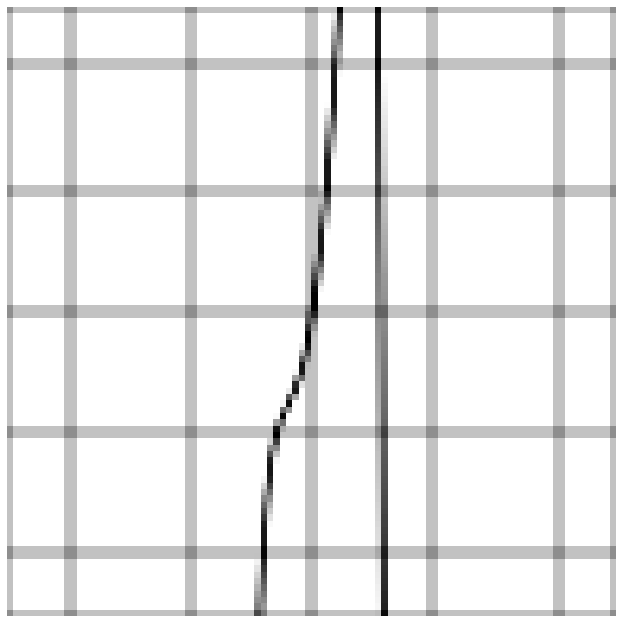

0


In [5]:


# get imaages
data_dir = 'C:\\Users\\the_3\\Desktop\\poly-curve-detector\\DataGeneration\\plotData'

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

sampledataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(sampledataset, batch_size=128)

images, labels = next(iter(dataloader))
figure = plt.figure(figsize=(24,24))
plots = 2
for i in range(1, plots + 1):
    sample_idx = torch.randint(len(sampledataset), size=(1,)).item()
    img, label = sampledataset[0]
    figure.add_subplot(1, plots, i)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    break
    
plt.show()
print(label)

In [6]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.005)

output = model.forward(images)
print(output)

tensor([[-1.5824e-03, -3.2622e-04, -6.2974e-05,  ..., -9.4820e-04,
         -6.0426e-04,  1.0618e-02],
        [-1.4037e-03, -4.5062e-04,  7.8111e-03,  ..., -1.1024e-03,
         -3.2663e-04, -1.3350e-04],
        [-1.2823e-03, -1.7501e-05,  3.2158e-02,  ..., -9.2304e-04,
         -9.7462e-05,  4.9878e-03],
        ...,
        [-1.1674e-03, -2.7535e-04,  2.0364e-02,  ..., -1.0147e-03,
         -3.1312e-04,  1.0136e-02],
        [-1.3645e-03, -1.4940e-04, -2.3828e-04,  ..., -1.0282e-03,
         -1.0107e-04, -2.7841e-05],
        [-1.4378e-03, -4.9497e-04, -1.8012e-04,  ..., -1.3734e-03,
         -5.4986e-04, -2.8739e-04]], grad_fn=<LeakyReluBackward0>)


In [7]:
print(output.shape)
output[0,]

torch.Size([128, 8])


tensor([-1.5824e-03, -3.2622e-04, -6.2974e-05, -1.6999e-04,  1.3026e-02,
        -9.4820e-04, -6.0426e-04,  1.0618e-02], grad_fn=<SelectBackward>)

In [8]:
# TODO A: Train model on the data set
    # TODO 1: dataloader be able load (image: tensor, label:string) example of the label tensor([10,-4,-5,3,-2,-3,-2,2]) 
    # DONE 2: fix dimensionality so the net can feedforward a batch of images correctly, move the training to gpu when available
    # TODO 3: make trainloader and testloader dataloaders
# TODO B: Improve model
    # DONE 4: update checkpoint structure to save model and load model
# Brandon: 1, 3 
# Josias: 2, 4

In [9]:
train(model=model, trainloader=dataloader, testloader=dataloader, criterion=model.criterion, optimizer=optimizer, epochs=30)
output = model.forward(images)
print(output)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [8, 1, 3, 3], but got 2-dimensional input of size [128, 9216] instead

In [ ]:
model.save('C:\\Users\\the_3\\Desktop\\poly-curve-detector\\Model')

In [ ]:
new_model = Network()
Network.load_checkpoint(new_model, "C:\\Users\\the_3\\Desktop\\poly-curve-detector\\Model\\model_checkpoint.pth")

Network(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxPool2d(kernel_size=2, stride=2